<a href="https://colab.research.google.com/github/natalialopezg/Monografia-EACD/blob/master/Polyp_Segmentation_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a name="polyp-segmentationt"></a>
# Polyp Segmentation

<a name="objectives"></a>
## Objective
In the previous notebook, we have explored the polyp images and masks, as well as preprocessing and split data into train, validation, and test set.


## Table of contents
  * [Polyp Segmentation](#polyp-segmentation)
    * [Objective](#objectives)
    * [Table of Contents](#table-of-contents)
    * [Library import](#library-import)
    * [Load data](#load-data)
    * [Functions definition](#functions-definition)
    * [Classes and methods definition](#classes-methods-definition)
    * [Variational Autoencoder Model](#vae-model)
      * [Model configuration](#model-configuration)
      * [Model training](#model-training)
      * [Model evaluation](#model-evaluation)
        * [Confusion matrix](#confusion-matrix)
        * [Classification report](#classification-report)
        * [IoU and Dice Coefficient](#iou-and-dice-coefficient)
      * [Mask prediction](#mask-prediction)
      * [Reconstructed image](#reconstructed-image)
      * [Conclusion](#conclusion)

<a name="library-import"></a>
## Library import

In [ ]:
# PyTorch and TorchVision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, models
import torchvision

# File and Data Handling
from PIL import Image
import os
import zipfile
import gdown

# Utilities and Typing
from typing import Callable, Optional
import pandas as pd
import numpy as np
import random

# Plotting and Visualization
import plotly.graph_objects as go
import plotly.io as pio
import nbformat
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

# Metrics and Evaluation
from sklearn.metrics import confusion_matrix, classification_report

# Probability Distributions
from torch.distributions import MultivariateNormal, Normal


<a name="load-data"></a>
## Load data

In [ ]:
# URL of the file to download
url = 'https://drive.google.com/uc?id=1-Qhg6uVCQEuGKCXe2QJv7y1oBJ3ov7vM'

# root_dir = '/tmp'
root_dir = r"C:\Users\nata-\OneDrive\Documentos\UDEA\data"

# Path to save the downloaded file locally
output_path = f"{root_dir}/prepared_data.zip"

# Download the file
gdown.download(url, output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1-Qhg6uVCQEuGKCXe2QJv7y1oBJ3ov7vM
From (redirected): https://drive.google.com/uc?id=1-Qhg6uVCQEuGKCXe2QJv7y1oBJ3ov7vM&confirm=t&uuid=97a8ef48-0f78-4f86-afb8-59e0ce3f7f0b
To: C:\Users\nata-\OneDrive\Documentos\UDEA\data\prepared_data.zip
100%|██████████| 30.8M/30.8M [00:20<00:00, 1.50MB/s]


'C:\\Users\\nata-\\OneDrive\\Documentos\\UDEA\\data/prepared_data.zip'

In [ ]:
# Extract data from zip
local_zip = output_path
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(f"{root_dir}/prepared_data")
zip_ref.close()

<a name="classes-methods-definition"></a>
## Classes and methods definition

In [ ]:
class CustomDataset(Dataset):
  """
    Custom dataset class for loading image and mask pairs from a directory.

    Args:
        root_dir (str): The root directory containing 'images' and 'masks' subdirectories.
        split (str): The split of the dataset to load ('train', 'val', or 'test').
        transform (callable, optional): Optional transform to be applied to the images and masks.

    Attributes:
        root_dir (str): The root directory containing 'images' and 'masks' subdirectories.
        split (str): The split of the dataset to load ('train', 'val', or 'test').
        transform (callable, optional): Optional transform to be applied to the images and masks.
        images_list (list): List of image file names.
        masks_list (list): List of mask file names.

  """
  def __init__(self, root_dir, split, transform=None):
      self.root_dir = root_dir
      self.split = split
      self.transform = transform
      self.images_list = os.listdir(os.path.join(root_dir, f'images/{split}'))
      self.masks_list = os.listdir(os.path.join(root_dir, f'masks/{split}'))

  def __len__(self):
    """
      Returns the total number of samples in the dataset.

      Returns:
          int: The number of samples in the dataset.
    """
    return len(self.images_list)

  def __getitem__(self, idx):
    """
      Retrieves and preprocesses the image and mask at the specified index.

      Args:
          idx (int): The index of the sample to retrieve.

      Returns:
          tuple: A tuple containing the preprocessed image and mask.
    """
    img_name = os.path.join(self.root_dir, f'images/{self.split}', self.images_list[idx])
    mask_name = os.path.join(self.root_dir, f'masks/{self.split}', self.masks_list[idx])
    image = Image.open(img_name).convert("RGB")
    mask = Image.open(mask_name).convert("L")

    if self.transform:
        image = self.transform(image)
        mask = self.transform(mask)

    return image, mask

class VAE(nn.Module):
  """
    Variational Autoencoder (VAE) neural network architecture.

    Args:
        latent_dim (int): The dimensionality of the latent space.
        kernel_size (int, optional): The size of the convolutional kernel. Defaults to 3.
        stride (int, optional): The stride of the convolution operation. Defaults to 2.
        padding (int, optional): The amount of zero-padding added to the input. Defaults to 1.
        output_padding (int, optional): Additional size added to one side of the output. Defaults to 1.

    Attributes:
        encoder (nn.Sequential): The encoder module comprising convolutional layers.
        fc_mu (nn.Linear): Fully connected layer for the mean of the latent distribution.
        fc_logvar (nn.Linear): Fully connected layer for the log-variance of the latent distribution.
        decoder_input (nn.Linear): Fully connected layer for the input of the decoder.
        decoder (nn.Sequential): The decoder module comprising transposed convolutional layers.
  """
  def __init__(self, latent_dim, kernel_size = 3, stride =2, padding = 1, output_padding = 1):
      super(VAE, self).__init__()

      # layer output image size  = [ [ ( Input size + (2 × padding) − (dilation × (kernel size−1)) − 1 ) / stride ] +1 ]  | default: dilation=1
      # out_channels -> hidden channels

      # Define encoder
      self.encoder = nn.Sequential(
          nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size=kernel_size, stride=stride, padding=padding),  # 128x128
          nn.ReLU(),
          nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=kernel_size, stride=stride, padding=padding),  # 64x64
          nn.ReLU(),
          nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=kernel_size, stride=stride, padding=padding),  # 32x32
          nn.ReLU(),
          nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=kernel_size, stride=stride, padding=padding),  # 16x16
          nn.ReLU(),
          nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size=kernel_size, stride=stride, padding=padding),  # 8x8
          nn.ReLU(),
          nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size=kernel_size, stride=stride, padding=padding),  # 4x4
          nn.ReLU(),
          nn.Flatten(),
          nn.Dropout(p=0.3)
      )
      # Define fully connected layers for mean and log-variance
      self.fc_mu = nn.Linear(in_features = 1024 * 4 * 4, out_features = latent_dim) # in_features = hidden channels * h * w -> Last layer
      self.fc_logvar = nn.Linear(in_features = 1024 * 4 * 4, out_features = latent_dim)

      # Define decoder
      self.decoder_input = nn.Linear(in_features = latent_dim, out_features = 1024 * 4 * 4) # in_features Decoder = out_features Enconder
      self.decoder = nn.Sequential(
          nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding),  # 8x8
          nn.ReLU(),
          nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding),  # 16x16
          nn.ReLU(),
          nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding),  # 32x32
          nn.ReLU(),
          nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding),  # 64x64
          nn.ReLU(),
          nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding),  # 128x128
          nn.ReLU(),
          nn.ConvTranspose2d(in_channels = 32, out_channels = 3, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding),  # 256x256
          nn.Sigmoid()
      )

  def reparameterize(self, mu, logvar):
    """
      Reparameterizes the given mean and log-variance using the reparameterization trick.

      Args:
          mu (torch.Tensor): The mean of the latent Gaussian distribution.
              Shape: (batch_size, latent_dim)
          logvar (torch.Tensor): The log-variance of the latent Gaussian distribution.
              Shape: (batch_size, latent_dim)

      Returns:
          torch.Tensor: A tensor sampled from the latent Gaussian distribution parameterized
              by `mu` and `logvar` using the reparameterization trick.
              Shape: (batch_size, latent_dim)
    """
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

  def forward(self, x):
    """
      Forward pass through the VAE architecture.

      Args:
          x (torch.Tensor): The input tensor.
              Shape: (batch_size, channels, height, width)

      Returns:
          tuple: A tuple containing the reconstructed image, mean, and log-variance of the latent distribution.
    """
    # Encoder
    x = self.encoder(x)
    mu = self.fc_mu(x)
    logvar = self.fc_logvar(x)
    # Reparameterize
    z = self.reparameterize(mu, logvar)
    z = self.decoder_input(z)
    z = z.view(-1, 1024, 4, 4)
    # Decoder
    x_dec = self.decoder(z)
    return x_dec, mu, logvar



<a name="functions-definition"></a>
## Functions definition

In [ ]:
def get_device():
  """
    Returns the appropriate device for computation: CUDA (GPU) if available, otherwise CPU.

    Returns:
        torch.device: The device (CUDA/GPU or CPU) for computation.
  """
  return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def vae_loss(recon_x, x, mu, logvar, variational_beta = 1):
  """
    Calculates the loss for a Variational Autoencoder (VAE).

    Args:
        recon_x (torch.Tensor): The reconstructed output from the VAE.
        x (torch.Tensor): The original input to the VAE.
        mu (torch.Tensor): The mean of the latent distribution.
        logvar (torch.Tensor): The log-variance of the latent distribution.
        variational_beta (float, optional): The weight for the KL divergence term.
                                              Defaults to 1.

    Returns:
        torch.Tensor: The total loss calculated as a combination of reconstruction loss
                      and KL divergence loss.

  """
  recon_loss = F.binary_cross_entropy(recon_x.view(-1, 1024), x.view(-1, 1024), reduction='sum')

  kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  loss = recon_loss + variational_beta * kldivergence
  return loss

def make_averager() -> Callable[[Optional[float]], float]:
  """
    Returns a function that maintains a running average.

    The returned function updates the running average with each new value.
    If called with None, it returns the current average.

    Returns:
        Callable[[Optional[float]], float]: Function to update and get the running average.

  """
  count = 0
  total = 0

  def averager(new_value: Optional[float]) -> float:
      """
        Updates and returns the running average.

        Args:
            new_value (Optional[float]): The number to add to the running average.
                                          If None, returns the current average.

        Returns:
            float: The current average of the numbers seen so far, or NaN if no numbers
                    have been added yet.
      """
      nonlocal count, total
      if new_value is None:
          return total / count if count else float("nan")
      count += 1
      total += new_value
      return total / count

  return averager

def refresh_bar(bar, desc):
  """
    Update the description of a progress bar and refresh its display.

    Args:
        bar (tqdm.std.tqdm): The progress bar object to update.
        desc (str): The new description for the progress bar.
  """
  bar.set_description(desc)
  bar.refresh()

def dice_coefficient(y_true, y_pred):
  """
    Computes the Dice coefficient (F1 score) between two binary segmentation masks.

    The Dice coefficient is defined as the ratio of twice the intersection of the
    two masks to the sum of the number of pixels in each mask.

    Args:
        y_true (numpy.ndarray): Ground truth binary segmentation mask.
        y_pred (numpy.ndarray): Predicted binary segmentation mask.

    Returns:
        tuple: A tuple containing the numerator and denominator of the Dice coefficient.

  """
  intersection = np.sum(y_true * y_pred)
  dice_numerator = 2.0 * intersection
  dice_denominator = np.sum(y_true) + np.sum(y_pred)
  return dice_numerator, dice_denominator

def evaluate(model, dataloader):
  """
    Evaluate the model on a validation dataset.

    Args:
        model: The trained model to evaluate.
        dataloader: The DataLoader containing the validation dataset.

    Returns:
        float: The average loss on the validation dataset.
  """
  model.eval()  # Set the model to evaluation mode

  total_loss = 0.0
  num_batches = 0

  with torch.no_grad():
      for images, labels in dataloader:

        if labels.size(1) == 1:
          labels = torch.cat([labels] * 3, dim=1)

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Compute loss (e.g., using a predefined loss function)
        loss = vae_loss(outputs[0], labels, outputs[1], outputs[2], variational_beta=1)

        total_loss += loss.item()
        num_batches += 1

  # Calculate average loss
  avg_loss = total_loss / num_batches

  return avg_loss

def reconstruct_image(image, model):
  """
    Reconstructs an image using a trained model.

    Args:
        image (torch.Tensor): The input image tensor to be reconstructed.
        model (torch.nn.Module): The trained model used for reconstruction.

    Returns:
        torch.Tensor: The reconstructed image tensor.
  """
  model.eval()
  with torch.no_grad():
      image, _, _ = model(image.unsqueeze(0).to(device))
      image = image.clamp(0, 1)
      return image.squeeze().cpu()

def save_in_dataframe(df_log, labels, mus, stddevs, epoch):
  """
    Save the given statistics into a DataFrame and append it to the existing log DataFrame.

    Parameters:
    df_log (pd.DataFrame): The existing DataFrame log to append the new data.
    labels (torch.Tensor): The labels associated with the data points.
    mus (np.ndarray): The means (mu) of the latent variables for each data point.
    stddevs (np.ndarray): The standard deviations (stddev) of the latent variables for each data point.
    epoch (int): The current epoch number.

    Returns:
    pd.DataFrame: The updated DataFrame log with the new data appended.
  """
  df = pd.DataFrame()

  df['index'] = np.arange(len(mus[:,0])) * epoch
  df['image_ind'] = np.arange(len(mus[:,0]))
  # df['class'] = labels.data.numpy().astype(str)
  df['mu_x'] = mus[:,0]
  df['mu_y'] = mus[:,1]
  df['std_x'] = stddevs[:,0]
  df['std_y'] = stddevs[:,1]
  df['epoch'] = np.ones(len(mus[:,0])) * epoch

  df_log = pd.concat([df_log, df])

  return df_log

def run_on_testbatch(df_log, vae, epoch, x, y):
  """
    Run the VAE model on a test batch, extract statistics, and save them to the log DataFrame.

    Parameters:
    df_log (pd.DataFrame): The existing DataFrame log to append the new data.
    vae (torch.nn.Module): The trained VAE model.
    epoch (int): The current epoch number.
    x (torch.Tensor): The input data batch.
    y (torch.Tensor): The labels for the input data batch.

    Returns:
    pd.DataFrame: The updated DataFrame log with the new data appended.
  """
  with torch.no_grad():
      x = x.to(device)
      x, mus, stddevs = vae(x)
      x = x.to('cpu')
      mus = mus.to('cpu').data.numpy()
      stddevs = stddevs.to('cpu').mul(0.5).exp_().data.numpy()

  return save_in_dataframe(df_log, y, mus, stddevs, epoch)

<a name="vae-model"></a>
## Variational Autoenconder Model

<a name="model-configuration"></a>
### Model configuration

In [ ]:
# Hyperparameters VAE
latent_dim = 128
kernel_size = 3
stride =2
padding = 1

# Hyperparameters training
batch_size = 64
lr = 0.001
epochs = 100
variational_beta = 1

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()       # Converts to tensor and scales pixel values to [0, 1]
    # RescalePixels()              # Ensures the pixel values are rescaled appropriately
    # ,
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Rescaling pixels
])

In [ ]:
# Set device
device = get_device()

# Load train dataset
train_dataset = CustomDataset(root_dir= f"{root_dir}/prepared_data/train", split='train', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Load validation dataset
val_dataset = CustomDataset(root_dir= f"{root_dir}/prepared_data/valid", split='valid', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Load test dataset
test_dataset = CustomDataset(root_dir= f"{root_dir}/prepared_data/test", split='test', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
model = VAE(latent_dim = latent_dim,kernel_size = kernel_size, stride = stride, padding = padding).to(device)

# Optimization algorithm
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

# Number of params
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params:,}")


Number of parameters: 18,883,459


<a name="model-training"></a>
### Model training

In [ ]:
# Initialize log dataframe to store statistics
df_log = pd.DataFrame()

# Run the VAE model on a test batch, extract statistics, and save them to the log DataFrame
test_batch_x, test_batch_y = next(iter(val_dataloader))
df_log = run_on_testbatch(df_log, model, 0, test_batch_x, test_batch_y)

# Initialize list for running average
train_loss_avg = []

# Initialize history dictionary to store training metrics
history = {'loss': [], 'val_loss': []}

print('Training ...')

tqdm_bar = tqdm(range(1, epochs+1), desc="epoch [loss: ...]")
for epoch in tqdm_bar:
  # Get the running average
  train_loss_averager = make_averager()

  batch_bar =  tqdm(train_dataloader, leave=False, desc='batch', total=len(train_dataloader))
  for image_batch, _ in batch_bar:
    # Move tensor to device (CPU/GPU)
    image_batch = image_batch.to(device)

    # vae reconstruction
    image_batch_recon, latent_mu, latent_logvar = model(image_batch)

    # reconstruction error
    loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar, variational_beta = variational_beta)

    # backpropagation: calculating the gradient of the loss function
    optimizer.zero_grad()
    loss.backward()

    # one step of the optmizer
    optimizer.step()

    # Update the progress bar
    refresh_bar(batch_bar, f"train batch [loss: {train_loss_averager(loss.item()):.3f}]")

  # Update the progress bar
  refresh_bar(tqdm_bar, f"epoch [loss: {train_loss_averager(None):.3f}]")

  # training history
  history['loss'].append(train_loss_averager(None))
  validation_loss = evaluate(model, test_dataloader)
  history['val_loss'].append(validation_loss)
  train_loss_avg.append(train_loss_averager(None))
  df_log = run_on_testbatch(df_log, model, epoch, test_batch_x, test_batch_y )

df_log = df_log.set_index(['index'])

Training ...


epoch [loss: 5983483.542]: 100%|██████████| 100/100 [1:08:33<00:00, 41.13s/it]


In [ ]:
# Save model
torch.save(model.state_dict(), 'vae_segmentation_model.pth')

<a name="model-evaluation"></a>
### Model evaluation

In [ ]:
# Load the model
model = VAE(latent_dim).to(device)
model.load_state_dict(torch.load('vae_segmentation_model.pth'))
model.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): ReLU()
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Dropout(p=0.3, inplace=False)
  )
  (fc_mu): Linear(in_features=16384, out_features=128, bias=True)
  (fc_logvar): Linear(in_features=16384, out_features=128, bias=True)
  (decoder_input): Linear(in_features=128, out_features=16384, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output

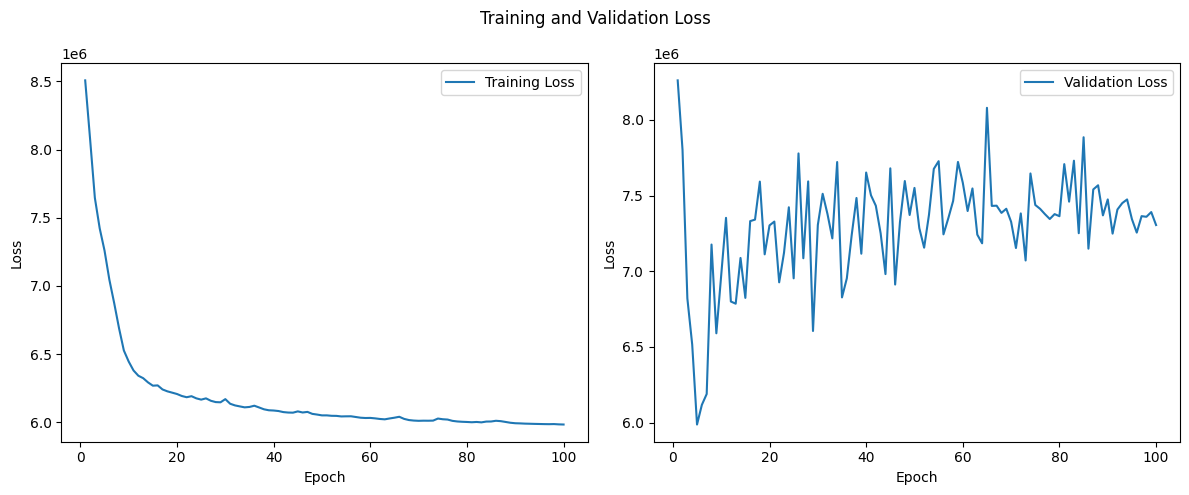

In [ ]:
# plot training and validation loss
loss = history['loss']
val_loss = history['val_loss']

fig, axes = plt.subplots(1,2, figsize=(12, 5))

axes[0].plot(range(1, len(loss) + 1), loss, label='Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

fig.suptitle('Training and Validation Loss')


# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

<a name="confusion-matrix"></a>
#### Confusion matrix

[[32965 26941]
 [ 3263  2367]]


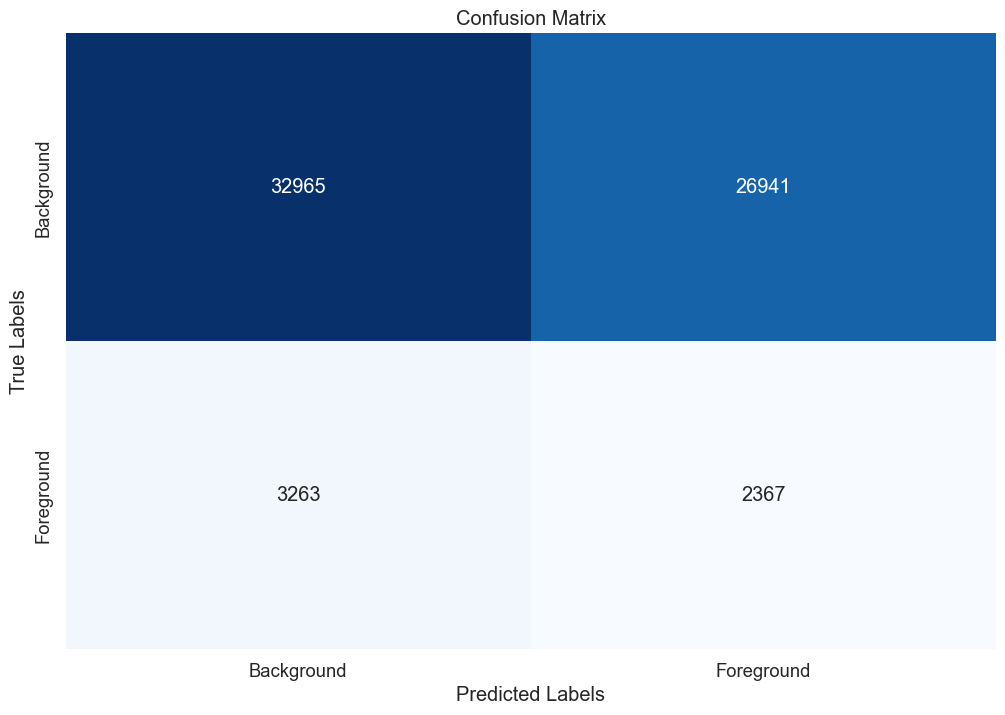

In [ ]:
# Set the model to evaluation mode
model.eval()

# Fetch a single batch of test images and masks from the dataloader
for data, target in test_dataloader:
    data, target = data.to(device), target.to(device)
    with torch.no_grad():
        recon_batch, mu, logvar = model(data)

    # Select the first image and mask from the batch for demonstration
    test_image = data[0].cpu().numpy().transpose(1, 2, 0)
    test_mask = target[0].cpu().numpy().transpose(1, 2, 0)
    prediction = recon_batch[0].cpu().numpy().transpose(1, 2, 0)

    # Convert predicted mask to single channel (grayscale)
    pred_gray = cv2.cvtColor(prediction, cv2.COLOR_RGB2GRAY)

    # Binarize the grayscale image using a threshold value
    _, binary_prediction = cv2.threshold(pred_gray, 0.5, 1, cv2.THRESH_BINARY)

    # Flatten the masks for comparison
    test_mask_flat = test_mask[:, :, 0].ravel()
    binary_prediction_flat = binary_prediction.ravel()

    # Convert binary masks to binary labels (0 or 1)
    test_mask_labels = (test_mask_flat > 0).astype(np.uint8)
    binary_prediction_labels = (binary_prediction_flat > 0).astype(np.uint8)

    # Create the confusion matrix
    conf_mat = confusion_matrix(test_mask_labels, binary_prediction_labels)
    print(conf_mat)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(12, 8))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Background", "Foreground"], yticklabels=["Background", "Foreground"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    break  # Only process the first batch


<a name="classification-report"></a>
#### Classification report


In [ ]:
class_names = ["Background", "Foreground"]

# Generate the classification report
report = classification_report(test_mask_labels, binary_prediction_labels, target_names=class_names)

print(report)

              precision    recall  f1-score   support

  Background       0.91      0.55      0.69     59906
  Foreground       0.08      0.42      0.14      5630

    accuracy                           0.54     65536
   macro avg       0.50      0.49      0.41     65536
weighted avg       0.84      0.54      0.64     65536



<a name="iou-and-dice-coefficient"></a>
#### IoU and Dice Coefficient

In [ ]:
# Initialize variables to store the total intersection, union, and sums for Dice coefficient
total_intersection = 0
total_union = 0
total_dice_numerator = 0
total_dice_denominator = 0

# Set the model to evaluation mode
model.eval()

# Compute Intersection over Union (IoU) and Dice coefficient for each batch in the test set
with torch.no_grad():
    for data, target in test_dataloader:
        data, target = data.to(device), target.to(device)
        recon_batch, mu, logvar = model(data)

        for img, pred, true_mask in zip(data, recon_batch, target):
            img = img.cpu().numpy().transpose(1, 2, 0)
            pred = pred.cpu().numpy().transpose(1, 2, 0)
            true_mask = true_mask.cpu().numpy().transpose(1, 2, 0)

            # Convert predicted mask to single channel (grayscale)
            pred_gray = cv2.cvtColor(pred, cv2.COLOR_RGB2GRAY)

            # Binarize the grayscale image using a threshold value
            _, pred_binary = cv2.threshold(pred_gray, 0.5, 1, cv2.THRESH_BINARY)

            # Compute intersection and union for the batch
            intersection = np.logical_and(true_mask[:, :, 0], pred_binary)
            union = np.logical_or(true_mask[:, :, 0], pred_binary)

            # Compute Dice coefficient for the batch
            dice_numerator, dice_denominator = dice_coefficient(true_mask[:, :, 0], pred_binary)

            # Update the totals
            total_intersection += np.sum(intersection)
            total_union += np.sum(union)
            total_dice_numerator += dice_numerator
            total_dice_denominator += dice_denominator

# Compute the mean IoU and Dice coefficient across all batches
mean_iou = total_intersection / total_union
mean_dice = total_dice_numerator / total_dice_denominator

# Print the mean IoU and Dice coefficient
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Dice Coefficient: {mean_dice:.4f}")


Mean IoU: 0.2292
Mean Dice Coefficient: 0.3583


<a name="mask-prediction"></a>
### Mask prediction

Random indices: [13, 68, 22, 104, 27]


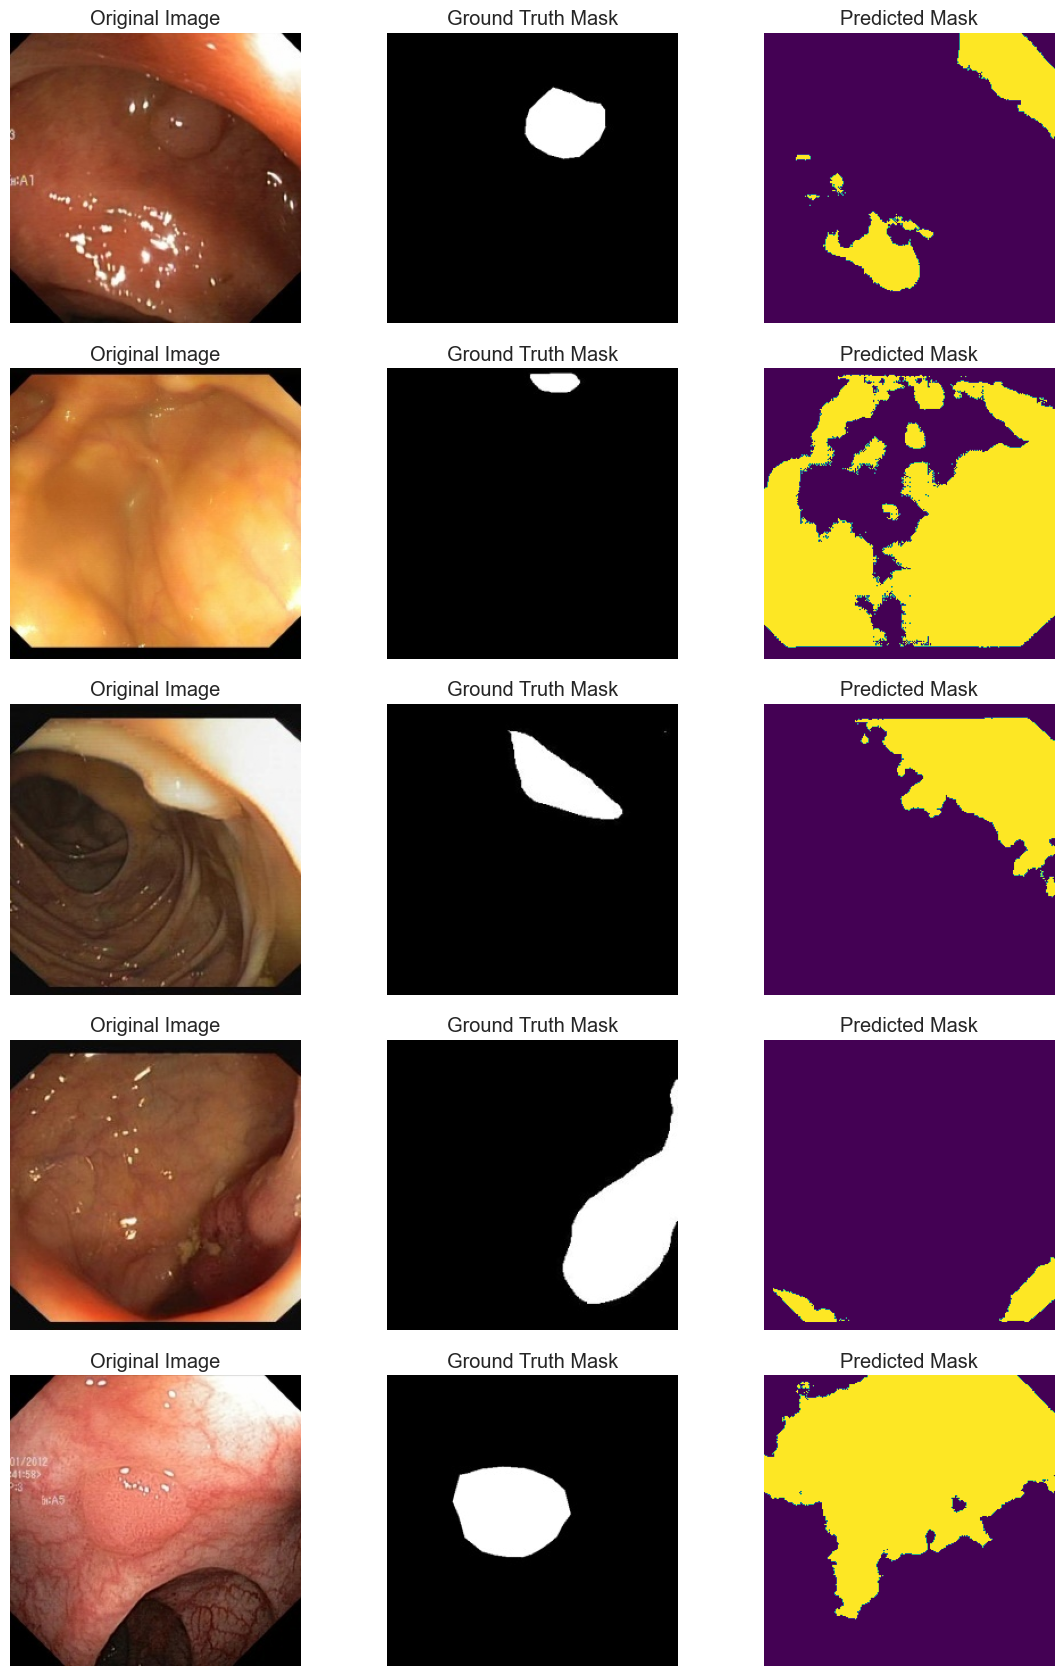

In [ ]:
# Fix the seed for reproducibility
random.seed(123)

# Set the model to evaluation mode
model.eval()

# Initialize lists to store images, ground truth masks, and predictions
images = []
true_masks = []
predictions = []

# Generate predictions for a batch of test images
with torch.no_grad():
    for data, target in test_dataloader:
        data, target = data.to(device), target.to(device)
        recon_batch, mu, logvar = model(data)

        # Convert tensors to numpy arrays and store them
        for img, pred, true_mask in zip(data, recon_batch, target):
            img = img.cpu().numpy().transpose(1, 2, 0)
            pred = pred.cpu().numpy().transpose(1, 2, 0)
            true_mask = true_mask.cpu().numpy().transpose(1, 2, 0)

            # Convert predicted mask to single channel (grayscale)
            pred_gray = cv2.cvtColor(pred, cv2.COLOR_RGB2GRAY)

            # Binarize the grayscale image using a threshold value
            _, pred_binary = cv2.threshold(pred_gray, 0.5, 1, cv2.THRESH_BINARY)

            images.append(img)
            true_masks.append(true_mask[:, :, 0])
            predictions.append(pred_binary)

# Get a random index to select 5 samples from the test batch
random_indices = random.sample(range(len(images)), 5)

# Print random indices
print(f"Random indices: {random_indices}")

# Initialize subplots
plt.figure(figsize=(12, 17))

for i, random_index in enumerate(random_indices):
    # Plot the image, ground truth mask, and predicted mask side by side
    plt.subplot(5, 3, i*3 + 1)
    plt.imshow(images[random_index])  # original image
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 2)
    plt.imshow(true_masks[random_index], cmap='gray')  # ground truth mask
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 3)
    plt.imshow(predictions[random_index], cmap='viridis')  # predicted mask
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

<a name="reconstructed-image"></a>
### Reconstructed image (decoder output)

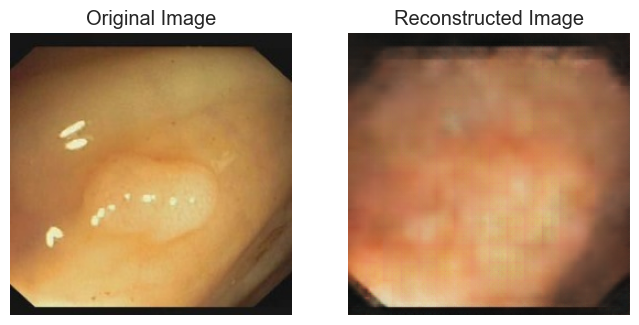

In [ ]:
# Fetch a single batch of test images and masks from the dataloader
for data, target in test_dataloader:
    data, target = data.to(device), target.to(device)
    with torch.no_grad():
        recon_batch, mu, logvar = model(data)

    # Select the first image and mask from the batch for demonstration
    test_image = data[0].cpu().numpy().transpose(1, 2, 0)
    test_mask = target[0].cpu().numpy().transpose(1, 2, 0)
    reconstructed_image = recon_batch[0].cpu().numpy().transpose(1, 2, 0)

# Plot the original and reconstructed images
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image)
plt.title("Reconstructed Image")
plt.axis('off')
plt.show()


<a name="conclusion"></a>
### Conclusion